# "Learning Rate and Momentum"
Aidan Morrison, 16/06/2020

In a previous post we looked at how different activation functions worked in a trivial case (one layer, one dimension). Two important hyper-parameters we just glossed over, namely learning rate and momentum.  It's often the case that these two will have defaults chosen which are a decent starting place.  However, in our trivial circumstances, a typical default learning rates (0.002, for example) is frustratingly slow.

In [21]:
import numpy as np
import torch
from torch import nn

from swarm import core, animator, networks, regimes

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (14.0, 12.0)

from typing import Iterable


In [22]:
NUM_BEES = 10
SEED = 10
NUM_EPOCHS = 250

def lr_hive(momentums: Iterable[float], lrs: Iterable[float]):
    # define the x and y
    x = torch.linspace(-5, 5, 61)
    y = torch.sin(x)
    # define the neural network training params that won't change
    static = {"x": x, "y": y, "width": 10, "hidden": 1, "num_epochs": NUM_EPOCHS}
    pm = core.make_combo_paramsets(
        static,
        # sweep across momentum
        momentum = momentums,
        # and learning rates
        lr=lrs,
    )
    # give us the results 
    res = core.hive_trainer(regimes.default_train, param_list=pm, num_bees=NUM_BEES, seed=SEED, fields="ypred,loss")
    return res

hive_data = lr_hive(momentums=[0.7,0.9, 0.95], lrs=[0.002, 0.01])

## How fast can you fit?

Here are some examples of swarms trying to fit the same sin curve as before, with a single hidden layer of width 10.  In this case we're sticking with the ReLU activation, since the clear kinks in the lines help to provide some clear visual clues.  After 250 epochs, the exact same architecture can either have fitted very well (perhaps nearly as much as 10 ReLUs might?) or have barely reached into the peaks of the curve at all.

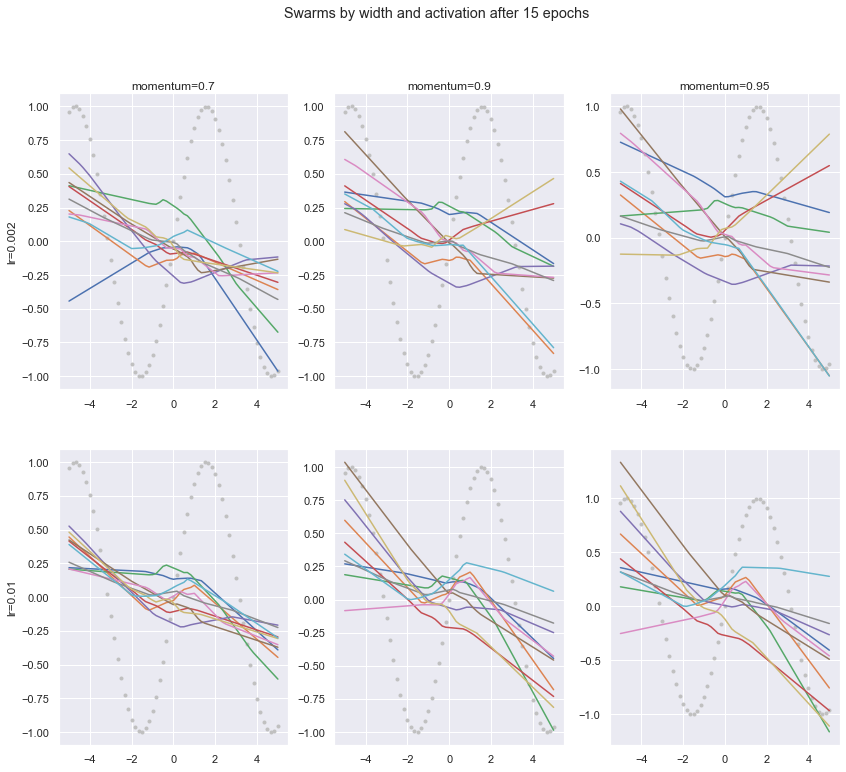

In [4]:
ans = animator.hive_plot(hive_data, "momentum", "lr", NUM_EPOCHS-1)
ans.suptitle(f"Swarms by width and activation after {NUM_EPOCHS} epochs");

Watching the animation of how this evolves is even more instructive.


In [11]:
plt.rcParams["figure.figsize"] = (10.0, 6.0)
animator.hive_animate(hive_data, "lr", "momentum", 'lrmom.mp4')
from IPython.display import Video
Video("lrmom.mp4", embed=True)

Saved to lrmom.mp4


There are a few things that jump right out.  Firstly, the overall rate at which the curves move and fit is much higher with both learning rate and momentum.  Whilst the notion of 'learning rate' directly implies that this should be the case, the relationship with momentum deserves a moment's thought. Increasing momentum seems to also increase the rate at which the 'bees' (individual network instances, or individual curves) find their fit.

### Velocity provides the link.

A little look into the mathematics underlying (in [pytorch](https://pytorch.org/docs/stable/optim.html)) explains things reasonably easily. The parameters after the next step of training (in this case, after an epoch) $p_{t+1}$ is given by:

$$p_{t+1} = p_{t} - lr*v_{t+1}$$
In simple language, it's the old parameters with a shift. The direction and magnitude of the shift is determined first by the velocity ($v_{t+1}$), and this is scaled by the learning rate.  However, the velocity itself has a relationship with the momentum (here denoted $\mu$):

$$v_{t+1} = \mu * v_{t} + g_{t+1}$$
Which demonstrates exactly what the momentum is doing.  Every time the velocity (movement for a step) is calculated, some fraction of the movement of the previous step is added. That fraction is the momentum.  Crucially, that resultant velocity is fed back in as the starting velocity at the next step. As a consequence, allowing more 'momentum' necessarily results in much higher overall velocities, or step-sizes, prior to the learning rate being applied to scale this back down.

### With little or no momentum: slow training or unstable gradients

What happens if we have no momentum, or barely any at all?  The bees only move in the exact direction of the gradient, as calculated by back-propagation at that step. We can have a look at that, albeit with some higher learning rates to compensate.

In [23]:
low_mom_hive = lr_hive(momentums=(0.0,0.1, 0.3), lrs=[0.01, 0.05])

In [13]:
plt.rcParams["figure.figsize"] = (10.0, 6.0)
animator.hive_animate(low_mom_hive, "lr", "momentum", 'low_mom.mp4')
from IPython.display import Video
Video("low_mom.mp4", embed=True)

Saved to low_mom.mp4


This demonstrates one of the hazards of high learning rates in general.  Gradients are a good indication of which direction to go, but not necessarily how far to go in it. Without suitable values for learning rate and momentum, a very clear direction to head can be interpreted as an instruction to take a large step in that direction.  This means that it's easy for networks to become unstable, as they might overshoot a clear, but near, optimum.

Adding momentum (instead of increasing the learning rate) in order to increase velocity moderates this problem.  It has the effect of saying 'only take a bigger step in that direction if you found that you were already heading in that direction in some of the previous steps'.

But in the previous low-momentum animation, you can see that in some cases an individual bee that was learning quite smoothly, can suddenly find itself with a node or two having a very steep gradient and moves too far in a single step. The gradients at the next point can be even larger, generally in something like the opposite direction, causing a bee to shake itself out of position before settling again.

In [34]:
beefilter = [d for d in low_mom_hive if d['momentum']==0 and d['lr']==0.05]
assert len(beefilter) == 1
bee = beefilter[0]
ypred = bee['ypred']

TypeError: list indices must be integers or slices, not str

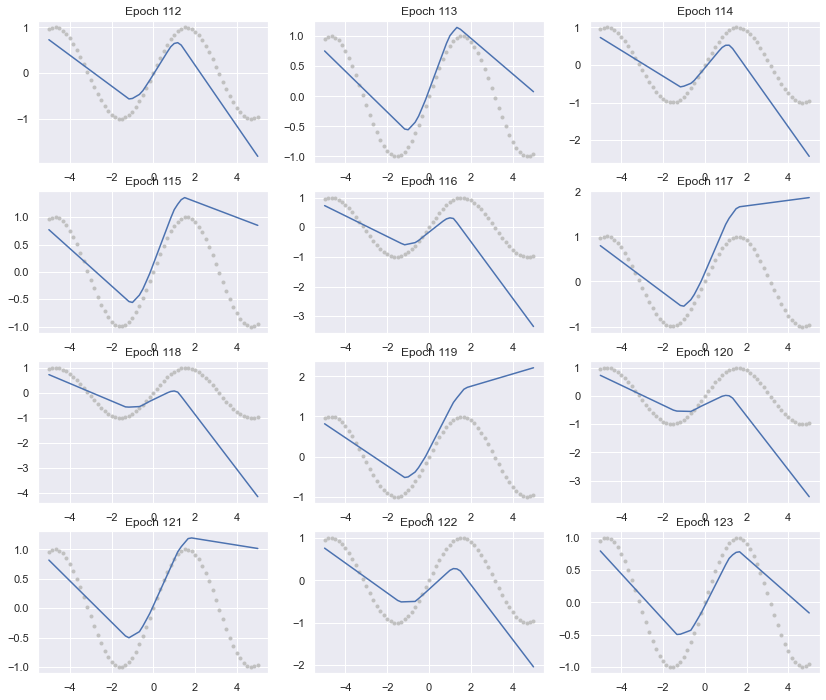

In [33]:
relevant_data = ypred[1, 112:124]

for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.plot(bee['x'], bee['y'], '.', color='silver')
    plt.plot(bee['x'], relevant_data[i])
    plt.title(f"Epoch {112 + i}")

## Add momomentum and bounce around!

Of course, using high momentum also comes with other costs.  If the direction you've recently been heading in is heavily weighted (relative to the gradient) when considering where to step next, it's easy to over-shoot and go a little bit too far. This means even individual bees bounce in and out of a position that might be a good fit, potentially multiple times before they come to settle (if they every do).

In [ ]:
bounce_hive = lr_hive(momentums=(0.9, 0.96, 0.99), lrs=[0.002, 0.01])

plt.rcParams["figure.figsize"] = (10.0, 6.0)
animator.hive_animate(bounce_hive, "lr", "momentum", 'bounce_hive.mp4')
from IPython.display import Video
Video("bounce_hive.mp4", embed=True)

As you can see, the higher momentum settings lead to plenty of bouncing around. You could easily characterise this learning process as being 'under-damped', since excess movement tends to stick around for a long time.  For the highest momentum, there isn't any smooth  path towards a low-loss solution, all of them continually overshoot, and don't come close to settling in a couple hundred epochs. Clearly momentum around 0.9-0.95 works very well in this application with learning rates around 1%.

### Explore or exploit?

So what would be the usefulness in stretching towards higher momentum, if it slows the speed of convergence towards a good fit? Well, being persistently 'unsettled', as the bees on the right are, isn't a bad attitude for exploration, if this is more important than optimising on the nearest solution. If you don't want to easily fall into the nearest local minimum, an bit of extra pep in the momentum is a good way of keeping the journey going. You may discover some more interesting features in the parameter space this way.

For instance, almost none of the bees in any of the regimes tested so far have made any effort to capture the final curves back away from 1 and -1 near the outer edges of the sin wave. The restless bees at momentum .99 and learning rate .01 explore strange kinks in all sorts of places. And several of the bees show clear efforts to capture this final inflection with some kinks out at the extremities, including quite early on in the training.

Of course, the challenge is to tame this voracious exploratory spirit, and capture something that is stable, and might be arrived at reasonably reliably.  There are other parameters available in pytorch including adding damping to the momentum, which may be part of a better solution.  In a future post, we'll also explore what happens when more layers are added, and the test what happens when we create multiple possible minima or add some noise to our target functions.

